In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples.csv')
df.shape

CPU times: user 26.9 s, sys: 3.04 s, total: 29.9 s
Wall time: 31.5 s


(17937758, 9)

In [3]:
df.head()

,source_word,target_word,source_fn,target_fn,set_name,speaker_id,book_id,distance_from_target,audio_fpath
0,I,FELT,8af4aebcf4a74004b02db9f88d99e89a,1cb9442ec1a6468282da309756e2ff57,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
1,I,THAT,8af4aebcf4a74004b02db9f88d99e89a,2f60546c930c47068ee0a129e6d51c39,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
2,FELT,I,1cb9442ec1a6468282da309756e2ff57,8af4aebcf4a74004b02db9f88d99e89a,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
3,FELT,THAT,1cb9442ec1a6468282da309756e2ff57,2f60546c930c47068ee0a129e6d51c39,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
4,FELT,IT,1cb9442ec1a6468282da309756e2ff57,155ad336d88c4cbf814a1237983b5b18,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac


In [4]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

In [5]:
train_examples.size, valid_examples.size

(159688530, 1751292)

In [6]:
max_length_of_example = 291
mean_length_of_exapmple = 29

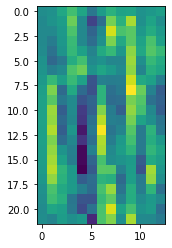

In [7]:
plt.imshow(pd.read_pickle('data/examples/1cb9442ec1a6468282da309756e2ff57.pkl'))

In [8]:
def prepare_features(row, col, pad_to=max_length_of_example, pad_left=False):
    ary = pd.read_pickle(f'data/examples/{row[col]}.pkl')
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [9]:
dss = Datasets(
    df,
    [lambda row: prepare_features(row, 'source_fn', pad_left=True),
     lambda row: prepare_features(row, 'target_fn'),
     lambda row: prepare_features(row, 'target_fn')],
    n_inp=2,
    splits = [train_examples.index, valid_examples.index]
)

In [10]:
BS = 32
LR = 1e-3
NUM_WORKERS = 8

train_dl = DataLoader(dss.train, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(dss.valid, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [11]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

In [12]:
class Model(Module):
    def __init__(self, hidden_size=50):
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.decoder = nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.lin = nn.Linear(hidden_size, 13)
            
    def forward(self, source_features, target_features):
        _, (embeddings, cell) = self.encoder(source_features)
        input = torch.cat(
            (
                target_features[:, :-1, :],
                embeddings.permute(1, 0, 2).repeat(1, target_features.shape[1]-1, 1)
            ), 2)
        x, _ = self.decoder(target_features[:, :-1, :], (embeddings, cell))
        return self.lin(x)

In [13]:
mse_loss = MSELoss()
def targ_trunc_MSE(preds, targs):
    return mse_loss(preds, targs[:, 1:, :])

learn = Learner(dls.cuda(), Model().cuda(), loss_func=targ_trunc_MSE, lr=1e-3, opt_func=SGD)

In [ ]:
learn.fit(1, cbs=SaveModelCallback(fname='1e-3_SGD', every_epoch=True), lr=1e-3)

## Calculate embedding for each unique word in the dataset

In [15]:
df_unique_utterances = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])].drop_duplicates(['source_fn'])
df_unique_utterances.reset_index(drop=True, inplace=True)

In [16]:
dss = Datasets(
    df_unique_utterances,
    [lambda row: prepare_features(row, 'source_fn', pad_left=True),
     lambda row: prepare_features(row, 'target_fn'),
     lambda row: prepare_features(row, 'target_fn')],
    n_inp=2,
)

In [17]:
all_utterances_dl = DataLoader(dss, BS, NUM_WORKERS, shuffle=True)

In [22]:
%%time

all_embeddings = []
with torch.no_grad():
    learn.model.train = False
    for batch in all_utterances_dl:
        _, (embeddings, _) = learn.model.encoder(batch[0].cuda())
        all_embeddings.append(embeddings.view(embeddings.shape[1], -1).detach().cpu())

CPU times: user 21min 18s, sys: 1min 40s, total: 22min 59s
Wall time: 31min 7s


In [23]:
all_embeddings = torch.cat(all_embeddings)

In [24]:
all_embeddings.shape

torch.Size([4638516, 50])

In [28]:
with torch.no_grad():
    for batch in all_utterances_dl:
        outputs = learn.model(batch[0].cuda(), batch[1].cuda())
        break

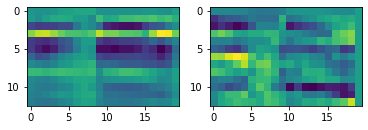

In [29]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[-1].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][-1].cpu().numpy().T[:, :20])

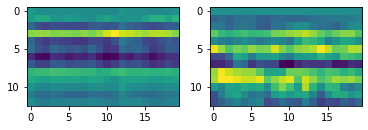

In [30]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[-10].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][-10].cpu().numpy().T[:, :20])

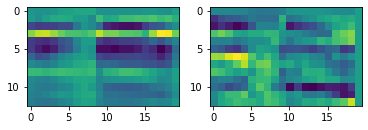

In [31]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[31].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][31].cpu().numpy().T[:, :20])

In [36]:
%%time

def empty_list(): return list()
word2row_idxs_unique_utterances = defaultdict(empty_list)

for idx, row in df_unique_utterances.iterrows():
    word2row_idxs_unique_utterances[row.source_word].append(idx)
    
pd.to_pickle(word2row_idxs_unique_utterances, 'word2row_idxs_unique_utterances.pkl')

CPU times: user 6min 33s, sys: 524 ms, total: 6min 33s
Wall time: 6min 33s


In [37]:
word2row_idxs_unique_utterances = pd.read_pickle('word2row_idxs_unique_utterances.pkl')

In [38]:
word2embedding = {}

for k, v in word2row_idxs_unique_utterances.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0)

In [40]:
word2embedding_without_nans= {}
nans_encountered = 0
for k, v in word2embedding.items():
    if k == k and (not np.isnan(v.numpy()).any()):
        word2embedding_without_nans[k] = v.numpy()
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

Encountered rows with nan values: 1


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [41]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [42]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [43]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [44]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116


In [45]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 242 words. Will replace them with mean vector
Missing 49 words. Will replace them with mean vector
Missing 11 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.05871441076408025
Spearman correlation of scores on WS353 -0.058045558502369775
Spearman correlation of scores on SIMLEX999 -0.14823016901638428
